In [1]:
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
from datasets import load_from_disk
from tqdm import tqdm
import gc

/workspace/py_venvs/qdora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# llama_3_1_8b_scores =[(0, 0.9580825),
#  (31, 0.92623705),
#  (1, 0.8153315),
#  (2, 0.80458987),
#  (11, 0.80011815),
#  (7, 0.79400295),
#  (8, 0.79155374),
#  (9, 0.7888252),
#  (10, 0.787708),
#  (12, 0.78395313),
#  (6, 0.7835098),
#  (3, 0.7756592),
#  (4, 0.7750059),
#  (5, 0.77466995),
#  (30, 0.7636904),
#  (14, 0.7552764),
#  (13, 0.75454295),
#  (15, 0.751751),
#  (22, 0.7497519),
#  (23, 0.74807227),
#  (21, 0.74428517),
#  (24, 0.741667),
#  (25, 0.73850685),
#  (29, 0.73773825),
#  (16, 0.7371719),
#  (17, 0.73509866),
#  (26, 0.7345957),
#  (20, 0.73239255),
#  (18, 0.732166),
#  (27, 0.72729003),
#  (19, 0.72527736),
#  (28, 0.7247871)]

# llama_3_1_70b_scores = [(0, 0.978506),
#  (79, 0.91416454),
#  (19, 0.8285857),
#  (20, 0.8226407),
#  (18, 0.8223146),
#  (17, 0.81696045),
#  (21, 0.81509286),
#  (22, 0.8083229),
#  (23, 0.80442375),
#  (16, 0.8007189),
#  (24, 0.7973383),
#  (26, 0.7971922),
#  (29, 0.7965952),
#  (78, 0.7950787),
#  (25, 0.7948524),
#  (30, 0.79155916),
#  (27, 0.79107267),
#  (15, 0.7897967),
#  (28, 0.7891356),
#  (31, 0.7869454),
#  (14, 0.7855198),
#  (32, 0.78331006),
#  (56, 0.7714719),
#  (55, 0.7707395),
#  (68, 0.77016747),
#  (33, 0.7700908),
#  (57, 0.7693299),
#  (67, 0.7690697),
#  (13, 0.7684531),
#  (71, 0.7676334),
#  (59, 0.7674676),
#  (72, 0.76705956),
#  (54, 0.76704353),
#  (58, 0.7669811),
#  (47, 0.76684034),
#  (53, 0.7666853),
#  (70, 0.7666158),
#  (52, 0.76642513),
#  (48, 0.7659957),
#  (40, 0.76586026),
#  (60, 0.76554656),
#  (36, 0.7654147),
#  (63, 0.76476604),
#  (51, 0.7642671),
#  (44, 0.76409954),
#  (50, 0.7630339),
#  (64, 0.7627203),
#  (41, 0.7626258),
#  (49, 0.7623532),
#  (69, 0.7623104),
#  (66, 0.7621464),
#  (43, 0.7616671),
#  (45, 0.76109684),
#  (73, 0.7605747),
#  (46, 0.7604856),
#  (42, 0.7604214),
#  (39, 0.7596355),
#  (61, 0.7583471),
#  (62, 0.75832576),
#  (37, 0.7581974),
#  (34, 0.7577875),
#  (35, 0.7577662),
#  (74, 0.7573278),
#  (65, 0.757285),
#  (75, 0.75446403),
#  (77, 0.7530562),
#  (38, 0.7529564),
#  (76, 0.752322),
#  (12, 0.7487615),
#  (10, 0.7456197),
#  (11, 0.7439856),
#  (9, 0.7293532),
#  (7, 0.71686816),
#  (6, 0.7095315),
#  (8, 0.6997427),
#  (5, 0.6873806),
#  (3, 0.67287296),
#  (4, 0.6410384),
#  (2, 0.62671435),
#  (1, 0.6213183)]

In [3]:
def calculate_bi_score(model, input_ids):
    """
    Calculate the Block Influence (BI) score for a given model and input IDs.

    This function computes the BI score by evaluating the cosine similarity 
    between the hidden states of the model for consecutive layers. The BI score 
    is defined as 1 minus the mean cosine similarity, providing a measure of 
    how much influence one block (layer) has on the next.

    Args:
        model (nn.Module): The pre-trained model used for inference.
        input_ids (torch.Tensor): The input tensor containing token IDs.

    Returns:
        list: A list of BI scores for each pair of consecutive hidden states, 
               or None if an error occurs during computation.
    """
    # Get all hidden states
    input_shape = input_ids.shape
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=None, output_hidden_states=True)
    
    hidden_states = [h.to("cpu") for h in outputs.hidden_states]
    del outputs, input_ids
    gc.collect()
    torch.cuda.empty_cache()
    
    try:
        bi_scores = []
        for i in range(len(hidden_states) - 1):
            # Calculate cosine similarity
            similarity = nn.functional.cosine_similarity(hidden_states[i].to("cuda").unsqueeze(2), 
                                                         hidden_states[i+1].to("cuda").unsqueeze(1), dim=-1).to("cpu")
            # Calculate BI score
            bi_score = 1 - similarity.mean().item()
            bi_scores.append(bi_score)
        
        del hidden_states, similarity
        gc.collect()
        torch.cuda.empty_cache()
        return bi_scores
    except Exception as e:
        print(input_shape)
        return None

In [8]:
# Load pre-trained model and tokenizer
model_name = "meta-llama/Meta-Llama-3.1-70B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="auto")

In [9]:
def convert_to_chat_input(question):
    messages = [
        {"role": "system", "content": "You are a helpful AI assistant."},
        {"role": "user", "content": question},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [2]:
ds = load_from_disk("/workspace/data/llama_large_mix_dataset_v1_1536").shuffle(42)

In [ ]:
bi_scores = []

for i in tqdm(range(1000)):
	text = ds[i]['input_text']
	inputs = tokenizer(convert_to_chat_input(text), return_tensors="pt")
	if inputs['input_ids'].shape[1] < 1000:
		bi_scores.append(calculate_bi_score(model, inputs["input_ids"].cuda()))

In [8]:
inputs['input_ids'].shape

torch.Size([1, 97])

In [9]:
scores = list(enumerate(list(torch.tensor(bi_scores).mean(0).numpy())))

In [ ]:
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True); sorted_scores

In [12]:
len(bi_scores)

548

In [11]:
budget = 0.2
skip_adj = True
top_k = int(len(sorted_scores) * budget); top_k
selected_layers = []
for layer_idx, score in sorted_scores:
    # don't pick adjacent layers
	if skip_adj and (layer_idx-1 in selected_layers or layer_idx+1 in selected_layers):
		# print(f"Skipping layer {layer_idx}")
		continue
	if len(selected_layers) < top_k:
		selected_layers.append(layer_idx)
	
print(",".join(map(str, sorted(selected_layers))))
  

0,13,15,17,19,21,23,26,29,31,33,56,59,68,71,79


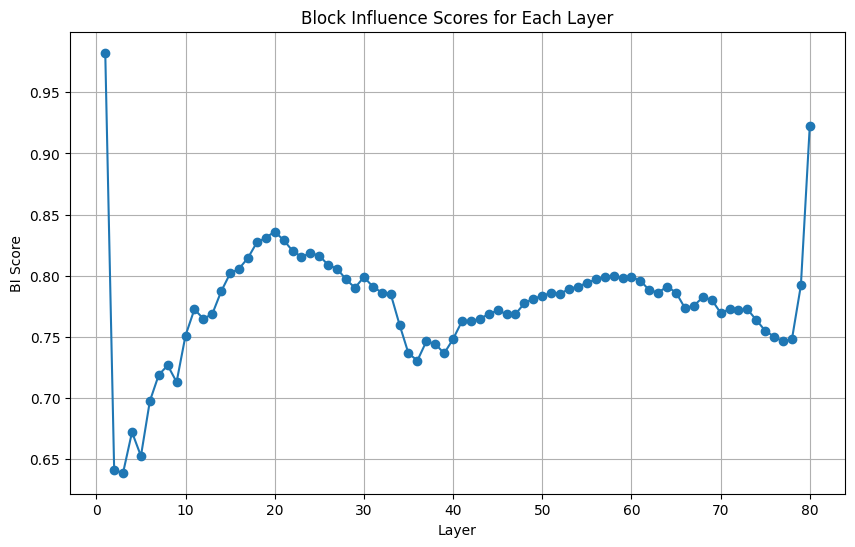

In [14]:
# Prepare input
text = """Here is python code to compute the BI score.

```python
def calculate_bi_score(model, input_ids, attention_mask):
    # Get all hidden states
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    
    hidden_states = outputs.hidden_states

    bi_scores = []
    for i in range(len(hidden_states) - 1):
        x_i = hidden_states[i]
        x_i_plus_1 = hidden_states[i + 1]
        
        # Calculate cosine similarity
        similarity = nn.functional.cosine_similarity(x_i.unsqueeze(2), x_i_plus_1.unsqueeze(1), dim=-1)
        
        # Calculate BI score
        bi_score = 1 - similarity.mean().item()
        bi_scores.append(bi_score)
    
    return bi_scores
```
"""
inputs = tokenizer(convert_to_chat_input(text), return_tensors="pt")


# Calculate BI scores
bi_scores = calculate_bi_score(model, inputs["input_ids"].cuda(), inputs["attention_mask"].cuda())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(bi_scores) + 1), bi_scores, marker='o')
plt.title("Block Influence Scores for Each Layer")
plt.xlabel("Layer")
plt.ylabel("BI Score")
plt.grid(True)
plt.show()

# # Print results
# for i, score in enumerate(bi_scores, 1):
# 	print(f"Layer {i}: BI Score = {score:.4f}")